In [141]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow is already loaded. Please restart the runtime to change versions.


https://neurowhai.tistory.com/292

# seq2seq with attention mechanism

In [1]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [2]:
from tensorflow.python.client import device_lib
import tensorflow as tf
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2265206407884039409, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13914434809359195673
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 569608369167759954
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 268424367306140864
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
from keras import layers, models
from __future__ import print_function
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Dropout, Embedding
import numpy as np
from keras import datasets
from keras import backend as K
from keras.utils import plot_model
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/drive/My Drive/jeju_real.txt'


# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n') # 각 문장. 일단 줄바꿈으로 한줄씩 불러옴
    
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

            #  제주어사투리와 번역표준어를 불러와서 줄로 나눈뒤
            #  탭으로 구분된 문장 나눔


Using TensorFlow backend.


In [6]:
# input_characters = set() ; target_characters = set() 
# 집합으로 되어있는 각각의 음절의 모음을 list 로 변형시킨후 자주나오는 빈도로 변형시킴

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('제주어 문장 총 갯수:', len(input_texts))
print('제주어 음절 수:', num_encoder_tokens)
print('표준어 음절 수 :', num_decoder_tokens)
print('제주어 문장의 음절 최대길이:', max_encoder_seq_length)
print('표준어 번역문장 음절 최대길이:', max_decoder_seq_length)


제주어 문장 총 갯수: 1174
제주어 음절 수: 777
표준어 음절 수 : 717
제주어 문장의 음절 최대길이: 165
표준어 번역문장 음절 최대길이: 183


In [7]:
# 문자 -> 숫자 변환용 사전
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# 음절 - 인덱스
print(input_token_index)
print(target_token_index)

{' ': 0, '!': 1, "'": 2, ',': 3, '.': 4, '0': 5, '1': 6, '3': 7, '4': 8, '5': 9, '?': 10, '`': 11, '가': 12, '각': 13, '간': 14, '갈': 15, '감': 16, '갑': 17, '갓': 18, '갔': 19, '강': 20, '같': 21, '개': 22, '갭': 23, '갯': 24, '갱': 25, '거': 26, '걱': 27, '건': 28, '걷': 29, '걸': 30, '검': 31, '것': 32, '겅': 33, '게': 34, '겐': 35, '겡': 36, '겨': 37, '겼': 38, '경': 39, '고': 40, '곡': 41, '곤': 42, '곧': 43, '골': 44, '곰': 45, '곱': 46, '곳': 47, '공': 48, '과': 49, '관': 50, '광': 51, '괭': 52, '괴': 53, '괸': 54, '교': 55, '구': 56, '국': 57, '군': 58, '굴': 59, '굶': 60, '굼': 61, '굽': 62, '굿': 63, '궂': 64, '궐': 65, '궤': 66, '귀': 67, '그': 68, '근': 69, '글': 70, '금': 71, '급': 72, '기': 73, '긴': 74, '길': 75, '김': 76, '깅': 77, '까': 78, '깍': 79, '깐': 80, '깝': 81, '깨': 82, '깬': 83, '깽': 84, '꺼': 85, '껀': 86, '껍': 87, '껏': 88, '께': 89, '껭': 90, '껴': 91, '꼬': 92, '꼭': 93, '꼴': 94, '꼼': 95, '꼽': 96, '꽃': 97, '꽈': 98, '꽉': 99, '꽝': 100, '꾸': 101, '꿀': 102, '꿈': 103, '꿩': 104, '꿰': 105, '뀐': 106, '끄': 107, '끅': 108, '끈': 109, '끌': 110,

In [8]:
# 숫자 -> 문자 변환용 사전
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


# 순서바꿈 : 인덱스 - 음절
print(reverse_input_char_index)
print(reverse_target_char_index)

{0: ' ', 1: '!', 2: "'", 3: ',', 4: '.', 5: '0', 6: '1', 7: '3', 8: '4', 9: '5', 10: '?', 11: '`', 12: '가', 13: '각', 14: '간', 15: '갈', 16: '감', 17: '갑', 18: '갓', 19: '갔', 20: '강', 21: '같', 22: '개', 23: '갭', 24: '갯', 25: '갱', 26: '거', 27: '걱', 28: '건', 29: '걷', 30: '걸', 31: '검', 32: '것', 33: '겅', 34: '게', 35: '겐', 36: '겡', 37: '겨', 38: '겼', 39: '경', 40: '고', 41: '곡', 42: '곤', 43: '곧', 44: '골', 45: '곰', 46: '곱', 47: '곳', 48: '공', 49: '과', 50: '관', 51: '광', 52: '괭', 53: '괴', 54: '괸', 55: '교', 56: '구', 57: '국', 58: '군', 59: '굴', 60: '굶', 61: '굼', 62: '굽', 63: '굿', 64: '궂', 65: '궐', 66: '궤', 67: '귀', 68: '그', 69: '근', 70: '글', 71: '금', 72: '급', 73: '기', 74: '긴', 75: '길', 76: '김', 77: '깅', 78: '까', 79: '깍', 80: '깐', 81: '깝', 82: '깨', 83: '깬', 84: '깽', 85: '꺼', 86: '껀', 87: '껍', 88: '껏', 89: '께', 90: '껭', 91: '껴', 92: '꼬', 93: '꼭', 94: '꼴', 95: '꼼', 96: '꼽', 97: '꽃', 98: '꽈', 99: '꽉', 100: '꽝', 101: '꾸', 102: '꿀', 103: '꿈', 104: '꿩', 105: '꿰', 106: '뀐', 107: '끄', 108: '끅', 109: '끈', 110: '끌',

In [9]:
# 학습에 사용할 데이터를 담을 3차원 배열
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# 문장을 문자 단위로 원 핫 인코딩하면서 학습용 데이터를 만듬
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

print(encoder_input_data[:3])
print(decoder_input_data[:3])
print(decoder_target_data[:3])

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[0. 0. 0. ... 

In [10]:
# 인코더 input                 제주어 음절수 최대길이:165. 제주어 구성하는 음절수:777
encoder_inputs = layers.Input(shape=(max_encoder_seq_length, num_encoder_tokens))
print(encoder_inputs.shape)

#input 인스턴스 해주고 GRU 모델로 encoder 만들어줌
encoder = layers.GRU(latent_dim, dropout=0.25, recurrent_dropout=0.25, return_sequences=True, return_state=True)


# latent_dim = 256  # 음절이 워낙 많으니까 밀집벡터로 만들어서 인코더에 이용할것.



# GRU 인코더 1층짜리 만듦. 제주어 데이터 넣어서 히든셀 state 와 output 얻음
encoder_outputs, state_h = encoder(encoder_inputs)

print('\n\nencoder output 결과 밀집벡터 256차원으로 나옴',encoder_outputs.shape)
print('마지막 h 에서 나온 output', state_h.shape)
# dropout 전
# encoder = layers.GRU(latent_dim, return_sequences=True, return_state=True)



(?, 165, 777)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


encoder output 결과 밀집벡터 256차원으로 나옴 (?, ?, 256)
마지막 h 에서 나온 output (?, 256)


In [11]:
# 디코더 input                 표준어 음절수 최대길이:183  표준어 구성하는 음절수:717
decoder_inputs = layers.Input(shape=(max_decoder_seq_length, num_decoder_tokens))
print(decoder_inputs.shape)
#input 인스턴스 해주고 GRU 모델로 decoder 만들어줌
decoder = layers.GRU(latent_dim,dropout=0.25,recurrent_dropout=0.25, return_sequences=True, return_state=True)







# 제주어 인코더에 들어가서 나온 히든셀state 를 받아서 decoder로 들어감. attention 망을 거쳐서 hs 행렬벡터로 받아야하는데??
# 디코더로 들어가는 input 은 표준어번역 문장 : 인코더에서 나온 hidden state 와 decoder GRU 망을 거쳐서 번역기 돌아감
decoder_outputs, _ = decoder(decoder_inputs, initial_state=state_h) 

print('\n\ndecoder output 결과 밀집벡터 256차원으로 나옴',decoder_outputs.shape)
print('마지막 dh 에서 나온 output', state_h.shape)

# dropout 전
# decoder = layers.GRU(latent_dim, return_sequences=True, return_state=True)

(?, 183, 717)


decoder output 결과 밀집벡터 256차원으로 나옴 (?, ?, 256)
마지막 dh 에서 나온 output (?, 256)


https://neurowhai.tistory.com/292

# 이사람 홈페이지 순서대로 다시 짜보자.


# attention 생성
'''
어텐션의 기본 아이디어는 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 
인코더에서의 전체 입력 문장을 다시 한 번 참고한다는 점입니다. 
단, 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, 
해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 
집중(attention)해서 보게 됩니다.
'''

In [0]:
def RepeatVectorLayer(rep, axis):
  return layers.Lambda(lambda x: K.repeat_elements(K.expand_dims(x, axis), rep, axis),
                      lambda x: tuple((x[0],) + x[1:axis] + (rep,) + x[axis:]))
  
# repeat_elements 함수는 1차원에 벡터에 b=[01] 이 있다고 가정하면
# repeat_elements(b, rep=2, axis=0) 이렇게 적으면 행으로 
# 0 0
# 1 1
# 이런식으로 증가


# 
# K.expand_dims 은
# K.expand_dims(n,0) 이렇게적으면 2*2 행렬이 1*2*2 행렬로
# K.expand_dims(n,1) 이렇게적으면 2*2 행렬이 2*1*2 행렬로 차원을 증가시켜줌
# 기존엔 reshape 으로 하던걸 텐서에서는 K.expand_dims를 사용
#



# repeat함수랑  expand_dims 함수써서 텐서의 차원을 맞춰줌


- def RepeatVectorLayer(rep, axis):

repeat_d_layer = RepeatVectorLayer(max_encoder_seq_length, 2)

rep =인코더 음절구성 최대문장길이, axis=2

- def RepeatVectorLayer(rep, axis):

repeat_e_layer = RepeatVectorLayer(max_decoder_seq_length, 1)

rep = 디코더 음절구성 최대문장길이,  axis =1  





---



즉 2번쨰 차원에 1차원을 추가한거고
max_decoder_seq_length 값 만큼 차원 증가한거같네요



위에 책내용하고 expand_dims 함수 써서 텐서 차원 증가시키면서 값들을 
max_decoder_seq_length 이걸로 가득채우는거같네용

In [13]:
# 영택이 소스 아님. 
# 어텐션 메커니즘

repeat_d_layer = RepeatVectorLayer(max_encoder_seq_length, 2) # 인코더에 들어간 제주어최대문장길이를 넣어주고 4차원 벡터로 만듦
repeat_d = repeat_d_layer(decoder_outputs)                    # 디코더를 통해서 나온 outputs : dh1
print('제주어 음절구성 최대길이, 2차원에 넣어주고 decoder_outputs : dh 를 행렬곱을 위해 repeat',repeat_d.shape) 
# 4차원 텐서로 바꿔줌. K.repeat_elements(K.expand_dims(x, axis), 최대문장길이 165, axis=2


repeat_e_layer = RepeatVectorLayer(max_decoder_seq_length, 1) # 디코더에 들어가는 표준어 최대문장길이, 4차원으로 만들어줌
repeat_e = repeat_e_layer(encoder_outputs) # encoder output : 제주어 : GRU 망을 거쳐서 나온 값....:  h1.h2.....ht

print('번역표준어 음절구성 최대길이, 2차원에 넣어주고 encoder_outputs : h 를 행렬곱을 위해 repeat',repeat_e.shape) 

# 제주어와 번역표준어 음절최대길이를 2차원, 3차원에 넣기 위해서 concat ???






# layers.Concatenate는 입력 목록을 연결하는 계층
# 연결 축을 제외하고 모두 동일한 모양의 텐서 목록을 입력으로 사용하고  모든 입력을  연결한 단일 텐서를 반환합니다.

concat_for_score_layer = layers.Concatenate(axis = -1)
concat_for_score = concat_for_score_layer([repeat_d, repeat_e])
print('\n\n제주어 음절최대길이, 표준어번역 음절최대길이 concat, 총 512밀집벡터 합쳐짐',concat_for_score.shape)






'''왜 이렇게 둘을 연결시켜주는지 이해가 안가는데, '''

제주어 음절구성 최대길이, 2차원에 넣어주고 decoder_outputs : dh 를 행렬곱을 위해 repeat (?, ?, 165, 256)
번역표준어 음절구성 최대길이, 2차원에 넣어주고 encoder_outputs : h 를 행렬곱을 위해 repeat (?, 183, ?, 256)


제주어 음절최대길이, 표준어번역 음절최대길이 concat, 총 512밀집벡터 합쳐짐 (?, 183, 165, 512)


'왜 이렇게 둘을 연결시켜주는지 이해가 안가는데, '


# 왜??????? 4차원으로 만들어서 제주어 음절최대길이, 표준어번역 음절최대길이 concat (?, 183, 165, 512)

![대체 텍스트](https://www.eksss.org/journal/pss/pss-11-1/gif/pss-11-1-41-g1.gif)



# 내가 아는 concat 은  Attention 을 통해서 각 attention score 구해지고 softmax 로 distribution 과정후 attention weight =at 를 구해서 각각의 h1,h2,h3,,, 이전에 나온 값들과 내적을 통해 가중치합을 = context vectore (그림에서 r) 로 만들고 Decoder 를 통해서 나온output (그림에서 c)을 연결해주고 다시 인코더로 들어감..

In [14]:
# 내가 아는 attention 망의 concat  =>  tanh(   Fully-connected(h1,h2,,,,ht) + FC(decoder h1)   )
# https://www.youtube.com/watch?v=WsQLdu2JMgI&t=38s

# 각각의 히든셀 값을 FC 만들고 디코더 이전output 과 합쳐서 tanh 계산해줘야함

# Dense 층으로 FC 완전연결계층 생성. tanh 활성화 함수 사용함.
# 여기서는 밀집벡터 //2 나눠준 값
# 256 //2 = 128 차원으로 줄이고 => 다음 Dense 층에서 1차원으로 Fully-connected 생성....
dense1_t_score_layer = layers.Dense(latent_dim // 2, activation='tanh') 
dense1_score_layer = layers.TimeDistributed(dense1_t_score_layer)
# 0-1 사이 정규화

dense1_score = dense1_score_layer(concat_for_score) # concat_for_score = concat_for_score_layer([repeat_d, repeat_e])
print('256차원 (제주어,표준어 최대길이 반영한) 밀집벡터 1/2 사이즈 줄임\t', dense1_score.shape)

'''왜 두개의 repeat 디코더 아웃풋과 repeat 인코더 아웃풋을 합쳐준 concat 레이어를 넣어주지? 
마지막 결과 (?, 183, 165) 를 만들어주기 위해서.....? 왜 두개의 최대길이를 넣어야하는지 모르겠다...'''


dense2_t_score_layer = layers.Dense(1) # attention 정규화를 거쳐서 나온 완전연결계층 : 1차원
dense2_score_layer = layers.TimeDistributed(dense2_t_score_layer) 


dense2_score = dense2_score_layer(dense1_score) 
print('\n\n1차원 FC 완전연결\t',dense2_score.shape)
dense2_score = layers.Reshape((max_decoder_seq_length, max_encoder_seq_length))(dense2_score)
                           # 표준어 문장 음절최대길이, 제주어 문장 음절최대길이  # 뒤에 (dense2_score)= 이건 input

                           # reshape( (165,183) ) : dense2_score 를 (165, 183) 모양으로 재배치 => 3차원으로 바꿔줌...?
print('Reshape 모양 재배치\t',dense2_score.shape)


# tanh 활성화 함수를 통해서 attention score 구했고
# fully-connected 되었으니 이제  softmax 함수를 들어가서 확률로 바꿀차례

softmax_score_layer = layers.Softmax(axis = -1) 
softmax_score = softmax_score_layer(dense2_score) # FC 완전연결층 넣어서 softmax 통과시킴.
print('attention score + softmax = 확률 정규화 결과', softmax_score.shape)
# attention score 구해지면 바로 distribution 정규화 시켜주고 

256차원 (제주어,표준어 최대길이 반영한) 밀집벡터 1/2 사이즈 줄임	 (?, 183, 165, 128)


1차원 FC 완전연결	 (?, 183, 165, 1)
Reshape 모양 재배치	 (?, 183, 165)
attention score + softmax = 확률 정규화 결과 (?, 183, 165)


In [15]:
# 왜 다시 256차원 밀집벡터 embedding 차원을 사용할까????

repeat_score_layer = RepeatVectorLayer(latent_dim, 2) 
repeat_score = repeat_score_layer(softmax_score) 
print("attention weight : 256밀집벡터를 2차원에 끼워넣고 확률 attetion_softmax_score를 반복시킴",repeat_score.shape)

# attention weight 을 구했으니 hidden state 값들과 내적을 진행하기 위해. repeat 함수를 이용해서 hs 만듦
print('\nhs 값이 256밀집벡터로 embeding 되었기때문에')


attention weight : 256밀집벡터를 2차원에 끼워넣고 확률 attetion_softmax_score를 반복시킴 (?, 183, 256, 165)

hs 값이 256밀집벡터로 embeding 되었기때문에


In [16]:
print('encoder_outputs ',encoder_outputs.shape)
permute_e = layers.Permute((2, 1))(encoder_outputs) 
print('repeat  hs 행렬벡터 : 행렬곱을 위해서 shape 치환',permute_e.shape)


repeat_e_layer = RepeatVectorLayer(max_decoder_seq_length, 1) 
repeat_e = repeat_e_layer(permute_e) 
print('위의 attention weight과 모양 맞춰서 decoder 최대길이 repeat',repeat_e.shape)


attended_mat_layer = layers.Multiply() 
# 가중치들이 반복된 행렬과 encoder output이 반복된 행렬끼리 곱을 하게 해서
attended_mat = attended_mat_layer([repeat_score, repeat_e]) 
# attention weight 생성.
context_layer = layers.Lambda(lambda x: K.sum(x, axis=-1), lambda x: tuple(x[:-1])) 
# 가중치합을 람다함수로 계산

# context 벡터 생성!!!!
context = context_layer(attended_mat) 

print('\n\n',decoder_inputs.shape)
print('표준어길이에 맞춰진 decoder input 과 동일한 183길이, 717개 음절은 너무 길어서 256개로 밀집벡터음절 embedding ', context.shape)


encoder_outputs  (?, ?, 256)
repeat  hs 행렬벡터 : 행렬곱을 위해서 shape 치환 (?, 256, ?)
위의 attention weight과 모양 맞춰서 decoder 최대길이 repeat (?, 183, 256, ?)


 (?, 183, 717)
표준어길이에 맞춰진 decoder input 과 동일한 183길이, 717개 음절은 너무 길어서 256개로 밀집벡터음절 embedding  (?, 183, 256)


케라스 Keras Documentation

- keras.layers.Permute(dims)

주어진 패턴에 따라서 input 차원을 치환한다.

순환 신경망과 convnet을 함께 연결하는 경우에 유용합니다.




---




- model.add(Permute((2, 1), input_shape=(10, 64)))

현재: model.output_shape == (None, 64, 10)

`None`은 배치 차원

In [17]:
# 인코더 attention 망을 거쳐서 나온 attention 가중치합까지 다 반영하면 만들어지는게 context 

# context 와 decoder_outputs : dh1 을 더해서 다음 예측을 위한 context 벡터를 만든다.
print('decoder GRU 통과하면 embedding 밀집벡터 형태로 output',decoder_outputs.shape)
concat_context_layer = layers.Concatenate(axis=-1) 
concat_context = concat_context_layer([context, decoder_outputs]) 
print('256차원 밀집벡터 embedding을 연결시켜서 512차원 증가',concat_context.shape) 

# 똑같이 tanh 활성화 함수로 들어가서 attention score => distribution => attention weight => 가중치합.

attention_dense_output_layer = layers.Dense(latent_dim, activation='tanh') 
attention_output_layer = layers.TimeDistributed(attention_dense_output_layer) 
attention_output = attention_output_layer(concat_context) 

print('\n\ndecoder 이전output 과 context vector가 tanh 함수에 의해 연산됨', attention_output.shape)

decoder_dense = layers.Dense(num_decoder_tokens, activation='softmax') 
decoder_outputs = decoder_dense(attention_output)
print('softmax 함수에 의해 확률값으로 반영해서 표준어 번역문장 음절에 맞춰서 예측값', decoder_outputs.shape )


decoder GRU 통과하면 embedding 밀집벡터 형태로 output (?, ?, 256)
256차원 밀집벡터 embedding을 연결시켜서 512차원 증가 (?, 183, 512)


decoder 이전output 과 context vector가 tanh 함수에 의해 연산됨 (?, 183, 256)
softmax 함수에 의해 확률값으로 반영해서 표준어 번역문장 음절에 맞춰서 예측값 (?, 183, 717)


# 모델 생성

In [18]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
che = 'keras_model1.model'
point = ModelCheckpoint(filepath=che , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=100)
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 165, 777)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 183, 717)     0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, 165, 256), ( 794112      input_1[0][0]                    
__________________________________________________________________________________________________
gru_2 (GRU)                     [(None, 183, 256), ( 748032      input_2[0][0]                    
                                                                 gru_1[0][1]              

In [0]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [19]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    verbose=1,callbacks=[point,early_stopping])
# Save model
model.save('s2s.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 939 samples, validate on 235 samples
Epoch 1/100





939/939 [==============================] - 23s 25ms/step - loss: 0.3640 - acc: 0.0120 - val_loss: 0.5524 - val_acc: 0.0252

Epoch 00001: val_loss improved from inf to 0.55241, saving model to keras_model1.model
Epoch 2/100
939/939 [==============================] - 14s 15ms/step - loss: 0.3078 - acc: 0.0127 - val_loss: 0.5501 - val_acc: 0.0252

Epoch 00002: val_loss improved from 0.55241 to 0.55015, saving model to keras_model1.model
Epoch 3/100
939/939 [==============================] - 14s 14ms/step - loss: 0.3044 - acc: 0.0130 - val_loss: 0.5475 - val_acc: 0.0241

Epoch 00003: val_loss improved from 0.55015 to 0.54749, saving model to keras_model1.model
Epoch 4/100
939/939 [==============================] - 14s 14ms/step - loss: 0.2997 - acc: 0.0137 - val_loss: 0.5378 - val_acc: 0.0280

Epoch 00004: val_loss improved from 0.5

In [20]:
# 샘플링 모델 정의
encoder_model = models.Model(encoder_inputs, [encoder_outputs, state_h])
encoder_outputs_input = layers.Input(shape=(max_encoder_seq_length, latent_dim))

decoder_inputs = layers.Input(shape=(1, num_decoder_tokens))
decoder_state_input_h = layers.Input(shape=(latent_dim,))
decoder_outputs, decoder_h = decoder(decoder_inputs, initial_state=decoder_state_input_h)

repeat_d_layer = RepeatVectorLayer(max_encoder_seq_length, 2)
repeat_d = repeat_d_layer(decoder_outputs)

repeat_e_layer = RepeatVectorLayer(1, axis=1)
repeat_e = repeat_e_layer(encoder_outputs_input)

concat_for_score_layer = layers.Concatenate(axis=-1)
concat_for_score = concat_for_score_layer([repeat_d, repeat_e])

dense1_score_layer = layers.TimeDistributed(dense1_t_score_layer)
dense1_score = dense1_score_layer(concat_for_score)

dense2_score_layer = layers.TimeDistributed(dense2_t_score_layer)
dense2_score = dense2_score_layer(dense1_score)
dense2_score = layers.Reshape((1, max_encoder_seq_length))(dense2_score)

softmax_score_layer = layers.Softmax(axis=-1)
softmax_score = softmax_score_layer(dense2_score)

repeat_score_layer = RepeatVectorLayer(latent_dim, 2)
repeat_score = repeat_score_layer(softmax_score)

permute_e = layers.Permute((2, 1))(encoder_outputs_input)
repeat_e_layer = RepeatVectorLayer(1, axis=1)
repeat_e = repeat_e_layer(permute_e)

attended_mat_layer = layers.Multiply()
attended_mat = attended_mat_layer([repeat_score, repeat_e])

context_layer = layers.Lambda(lambda x: K.sum(x, axis=-1),
                             lambda x: tuple(x[:-1]))
context = context_layer(attended_mat)

concat_context_layer = layers.Concatenate(axis=-1)
concat_context = concat_context_layer([context, decoder_outputs])

attention_output_layer = layers.TimeDistributed(attention_dense_output_layer)
attention_output = attention_output_layer(concat_context)

decoder_att_outputs = decoder_dense(attention_output)

decoder_model = models.Model([decoder_inputs, decoder_state_input_h, encoder_outputs_input],
                            [decoder_outputs, decoder_h, decoder_att_outputs])


def decode_sequence(input_seq):
  # 입력 문장을 인코딩
  enc_outputs, states_value = encoder_model.predict(input_seq)
 
  # 디코더의 입력으로 쓸 단일 문자
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  # 첫 입력은 시작 문자인 '\t'로 설정
  target_seq[0, 0, target_token_index['\t']] = 1.
 
  # 문장 생성
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    # 이전의 출력, 상태를 디코더에 넣어서 새로운 출력, 상태를 얻음
    # 이전 문자와 상태로 다음 문자와 상태를 얻는다고 보면 됨.
    dec_outputs, h, output_tokens = decoder_model.predict(
        [target_seq, states_value, enc_outputs])
 
    # 사전을 사용해서 원 핫 인코딩 출력을 실제 문자로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]
    decoded_sentence += sampled_char
 
    # 종료 문자가 나왔거나 문장 길이가 한계를 넘으면 종료
    if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
      stop_condition = True
 
    # 디코더의 다음 입력으로 쓸 데이터 갱신
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.
    
    states_value = h
 
  return decoded_sentence

for seq_index in range(30):
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('"{}" -> "{}"'.format(input_texts[seq_index], decoded_sentence.strip()))

"버래기" -> "병아리"
"강생이" -> "강아지"
"부각허다" -> "부글부글하다"
"강알" -> "수"
"부끄다" -> "부끄럽다"
"개끔" -> "바다"
"분시몰랑" -> "고르다"
"개작개작" -> "부부가 하다"
"삐암데기" -> "잠"
"검질" -> "찹쌀"
"속슴허라" -> "말하지 말하다"
"게미융허다" -> "희미하다"
"솜쫄르멍" -> "달"
"게작헌" -> "상갓닮은거"
"쉰달이" -> "산간"
"고라불켜" -> "고함지"
"심토맥이" -> "상복마"
"곡기다" -> "고기다"
"영" -> "감물들인옷"
"골다" -> "다리다"
"왁왁허다" -> "캄캄하다"
"곱지다" -> "숨기다"
"요망지다" -> "똑똑하다"
"과랑과랑" -> "쨍쨍하다"
"우영밭" -> "상복"
"괸당" -> "친"
"웃뜨리" -> "산간마"
"굽" -> "바다"
"재짝재짝" -> "걷는 모습"
"기시리다" -> "달리"


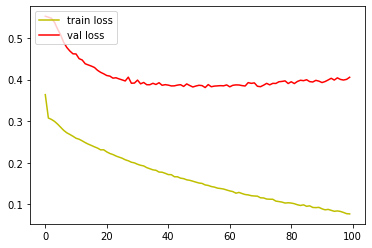

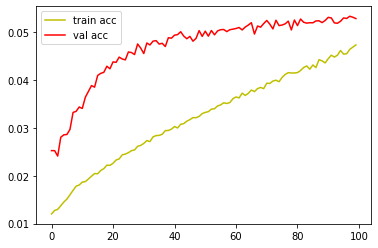

In [21]:
  # 손실 그래프
  plt.plot(history.history['loss'], 'y', label='train loss')
  plt.plot(history.history['val_loss'], 'r', label='val loss')
  plt.legend(loc='upper left')
  plt.show()

  # 정확도 그래프
  plt.plot(history.history['acc'], 'y', label='train acc')
  plt.plot(history.history['val_acc'], 'r', label='val acc')
  plt.legend(loc='upper left')
  plt.show()

In [22]:
result= []
for seq_index in range(1,200,1):
  
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('"{}" -> "{}"'.format(input_texts[seq_index], decoded_sentence.strip()))
  result.append(decoded_sentence.strip())

result

"강생이" -> "강아지"
"부각허다" -> "부글부글하다"
"강알" -> "수"
"부끄다" -> "부끄럽다"
"개끔" -> "바다"
"분시몰랑" -> "고르다"
"개작개작" -> "부부가 하다"
"삐암데기" -> "잠"
"검질" -> "찹쌀"
"속슴허라" -> "말하지 말하다"
"게미융허다" -> "희미하다"
"솜쫄르멍" -> "달"
"게작헌" -> "상갓닮은거"
"쉰달이" -> "산간"
"고라불켜" -> "고함지"
"심토맥이" -> "상복마"
"곡기다" -> "고기다"
"영" -> "감물들인옷"
"골다" -> "다리다"
"왁왁허다" -> "캄캄하다"
"곱지다" -> "숨기다"
"요망지다" -> "똑똑하다"
"과랑과랑" -> "쨍쨍하다"
"우영밭" -> "상복"
"괸당" -> "친"
"웃뜨리" -> "산간마"
"굽" -> "바다"
"재짝재짝" -> "걷는 모습"
"기시리다" -> "달리"
"제라헌" -> "제주"
"꽝" -> "뼈"
"조그물다" -> "물물이다"
"촐래" -> "반찬"
"주레사니" -> "제주도 오르는 모습니다"
"니치름" -> "바람"
"촘아가라" -> "아무지 말해 보아"
"데껴불켜" -> "던져버리다"
"칭원허다" -> "원통하다"
"두렁청허다" -> "떨떨하다"
"콥데사니" -> "버리"
"들러켬쩌" -> "날뛰다"
"코시롱" -> "향기"
"허다" -> "다니다"
"듬삭하다" -> "푸짐하다"
"탈" -> "씨앗"
"멜라지켜" -> "그러지다"
"통시" -> "감물들인옷"
"메기독딱" -> "얼굴"
"트멍" -> "주머니"
"모소완" -> "사모"
"하근디" -> "늑장부리다"
"몬뜨글락" -> "홀랑벗은모습"
"하다" -> "다니다"
"몬직당" -> "바다"
"몬짝" -> "감물들인옷"
"허당말타" -> "안하다"
"몰명허다" -> "개미하다"
"헌저글라" -> "그저께"
"몽케다" -> "까마리다"
"호썰" -> "조금"
"무리다" -> "무리다"
"호야" -> "시원하다"
"무사" -> "왜 그렇게 말입니다"
"흐랑허다" -> 

['강아지',
 '부글부글하다',
 '수',
 '부끄럽다',
 '바다',
 '고르다',
 '부부가 하다',
 '잠',
 '찹쌀',
 '말하지 말하다',
 '희미하다',
 '달',
 '상갓닮은거',
 '산간',
 '고함지',
 '상복마',
 '고기다',
 '감물들인옷',
 '다리다',
 '캄캄하다',
 '숨기다',
 '똑똑하다',
 '쨍쨍하다',
 '상복',
 '친',
 '산간마',
 '바다',
 '걷는 모습',
 '달리',
 '제주',
 '뼈',
 '물물이다',
 '반찬',
 '제주도 오르는 모습니다',
 '바람',
 '아무지 말해 보아',
 '던져버리다',
 '원통하다',
 '떨떨하다',
 '버리',
 '날뛰다',
 '향기',
 '다니다',
 '푸짐하다',
 '씨앗',
 '그러지다',
 '감물들인옷',
 '얼굴',
 '주머니',
 '사모',
 '늑장부리다',
 '홀랑벗은모습',
 '다니다',
 '바다',
 '감물들인옷',
 '안하다',
 '개미하다',
 '그저께',
 '까마리다',
 '조금',
 '무리다',
 '시원하다',
 '왜 그렇게 말입니다',
 '부지런하다',
 '희미하다',
 '미끄러지',
 '소리지',
 '모습',
 '물속옷',
 '바다',
 '바가지',
 '바다',
 '비가 날뛰는 산 날 쇠꼬리',
 '달무리 말하면 달려라',
 '날 날뛴다',
 '상복',
 '눈이 캄캄',
 '살',
 '산물을 많이 잡았다',
 '정말로 좋습니다',
 '덴 곳에 털 안히다',
 '바다가 잔잔하다',
 '산이',
 '작은 있는 바람',
 '물속으로',
 '버지',
 '버리지',
 '아버지',
 '어머니',
 '바다',
 '바다',
 '바가지',
 '바다',
 '아침',
 '남자',
 '나무',
 '감물들인옷',
 '사람이',
 '해녀',
 '경솔한사람',
 '아버지',
 '다',
 '무리',
 '닭',
 '뼈',
 '상복',
 '배',
 '등어리',
 '개구리',
 '멱살',
 '불뚝이',
 '아지',
 '상투',
 '머리',
 '상갓닮은거',
 '이',
 '종아

# 모델 검증

In [0]:
target_texts2 = []

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    _, target_text2 = line.split('\t')
    target_text2 = target_text2
    target_texts2.append(target_text2)

In [24]:
tar = target_texts2[1:200]
tar

['강아지',
 '부글부글하다',
 '가랭이',
 '부풀어 오르다',
 '거품',
 '정황도 모르고',
 '밥을 추하게 먹는 모습',
 '뺨',
 '잡초',
 '말하지말라',
 '희미하다',
 '숨막히는',
 '입이 큰',
 '유산식품',
 '고자질한다',
 '마음 씀씀이',
 '숨막히다',
 '이렇게',
 '잘게부수다',
 '캄캄하다',
 '숨기다',
 '똑똑하다',
 '햇살이 눈부시게 비추는모습',
 '텃밭',
 '친족',
 '산간마을',
 '밑바닥',
 '걷는 모습',
 '그을리다',
 '제대로 된',
 '뼈',
 '다물다',
 '반찬',
 '보리피리',
 '침',
 '어이없다',
 '던져버린다',
 '원통하다',
 '얼떨떨하다',
 '마늘',
 '날뛰다',
 '향기',
 '하다',
 '푸짐하다',
 '딸기',
 '찌그러지다',
 '돼지우리가 있는 변소',
 '아무것도 없음',
 '틈새',
 '무서워',
 '이곳저곳',
 '홀랑벗은모습',
 '많다',
 '만지다가',
 '전부',
 '하다가 안 할 것이냐',
 '멍청하다',
 '빨리가자',
 '늦장부리다',
 '조금',
 '맛이가다',
 '등',
 '왜?',
 '늘어지다',
 '어둠속에 빛이 희미하다',
 '얼굴',
 '고소하다',
 '모습',
 '잠수복',
 '거칠고 노한 바다',
 '가까운 바다',
 '먼 바다',
 '한라산의 중턱에 띠같은 구름이 끼면 비가 온다',
 '달무리지면 비가 온다',
 '돌고래가 날뛴다',
 '황사현상',
 '물안경',
 '작살',
 '해산물을 많이 잡았다',
 '해산물을 많이 잡았다',
 '겨우 한두개 잡았다',
 '바다가 잔잔하다',
 '산더미 같은 파도',
 '작은 파도',
 '물결이 친다',
 ' 할아버지',
 ' 할머니',
 '아버지',
 ' 어머니',
 ' 처녀',
 ' 친척',
 ' 거지',
 ' 색시',
 ' 의붓아들',
 ' 세번째자식',
 ' 사나이',
 ' 형님',
 ' 어른이된 사람',
 ' 해녀',
 ' 경솔한사람',
 ' 홀아비 ',
 ' 다리',


# 평가 BLEU



### 바이그램(Bigram) 단위로 카운트하여 Example 1, 2의 바이그램 정밀도(Bigram Precision)를 계산, 3gram, 4gram,,,ngram까지 정밀도 계산한다
![대체 텍스트](https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile2.uf.tistory.com%2Fimage%2F99B791335C67C9FE250064)
---

BLEU는 보정된 정밀도 p1,p2,...,pn를 모두 조합하여 사용합니다.
 (pn 에서 n은 n-gram에서의 n을 의미)

![대체 텍스트](https://sjiang1.github.io/talks/ASE2017/11.PNG)

https://wikidocs.net/31695

# 5) 짧은 문장 길이에 대한 패널티(Brevity Penalty)

문장의 길이가 짧다는 이유로 분모가 작기 때문에 높은 점수를 받는 것은 이상합니다. 그래서 Ca가 Ref보다 문장의 길이가 짧은 경우에는 점수에 패널티를 줄 필요가 있습니다. 이를 브레버티 패널티(Brevity Penalty)라고 합니다.

위의 수식은 패널티를 줄 필요가 없는 경우에는 BP의 값이 1이어야 함을 의미합니다. 이를 반영한 BP의 수식은 아래와 같습니다.

    BP = { 1          if c>r
         { e(1−r/c)   if c≤r

          c : Candidate의 길이
          r : Candidate와 가장 길이 차이가 작은 Reference의 길이

In [25]:
def dap(result, tar):
  import nltk.translate.bleu_score as bleu
  candidate = []
  references = []
  dap = []
  for i in range(0,len(result),1):
    re = []
    candidate = result[i]
    re.append(tar[i])
    dap.append(bleu.sentence_bleu(list(map(lambda ref: ref.split(), re)),candidate.split()))
  return sum(dap)/len(result)
# 성능테스트
dap(result,tar)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.2947545913700724